Sample code for _Price Revelation from Insider Trading: Evidence from Hacked Earnings News_


In [55]:
%matplotlib inline

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf
import warnings
import seaborn as sns
import seaborn as sns

warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
import matplotlib.cm as cm
from linearmodels import PanelOLS

# for latex plot format
from matplotlib import rc

rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)


In [57]:
# Load main file that includes all the main variables from all the datasets
ea_df = pd.read_hdf("../Proprietary Data (cannot be shared)/MainPanel.h5")


# Figure 1


In [58]:
def getNHacked(ea_df, newswire):
    news_ = (
        ea_df[(ea_df[newswire] == 1) & (ea_df["hacked"] == 1)]
        .groupby(["Year", "Month"])["SUE_Med"]
        .count()
        .reset_index()
    )
    news_["date"] = pd.to_datetime(
        news_["Year"].astype(str) + "-" + news_["Month"].astype(str) + "-01"
    )
    news_ = news_[["SUE_Med", "date"]].set_index("date")
    if newswire == "pr_newswire":
        news_.columns = ["PR Newswire"]
    elif newswire == "business_wire":
        news_.columns = ["Business Wire"]
    else:
        news_.columns = ["Marketwired"]
    news_.index = news_.index.to_period("M").to_timestamp("M")
    return news_


In [59]:
df = pd.DataFrame(index=pd.date_range(start="2010-01-01", end="2015-12-31", freq="M"))
pr = getNHacked(ea_df, "pr_newswire")
mw = getNHacked(ea_df, "marketwired")
bw = getNHacked(ea_df, "business_wire")

df = df.join(bw)
df = df.join(mw)
df = df.join(pr)
df.fillna(0, inplace=True)
df = df.resample("Q").sum()


In [60]:
# Proportion of earnings that are hacked over time
n = (
    ea_df.groupby(["hacked", "Year", "Quarter"])["lnMCAP"]
    .describe()[["count"]]
    .reset_index()
)
n_hack = n[n["hacked"] == 1]
n_hack = n_hack.groupby(["Year", "Quarter"])[["count"]].sum()
n_hack.columns = ["count_hacked"]
n = n.groupby(["Year", "Quarter"])[["count"]].sum()
n = n.join(n_hack)
n["Proportion of hacked obs."] = n["count_hacked"] / n["count"]
n["Proportion of hacked obs."].fillna(0, inplace=True)
n = n.reset_index()
n["Quarter"] = n["Quarter"] * 3
n["date"] = n["Year"].astype(str) + "-" + n["Quarter"].astype(str) + "-01"
n["date"] = pd.to_datetime(n["date"])
n["date"] = n["date"] + pd.offsets.MonthEnd(0)
n = n.set_index("date")
n = n[["Proportion of hacked obs."]]
n["Proportion of hacked obs."] = np.where(
    n["Proportion of hacked obs."] == 0, np.nan, n["Proportion of hacked obs."]
)
dates = n.index
n_hack.index = range(len(n_hack))
n.index = range(len(n))


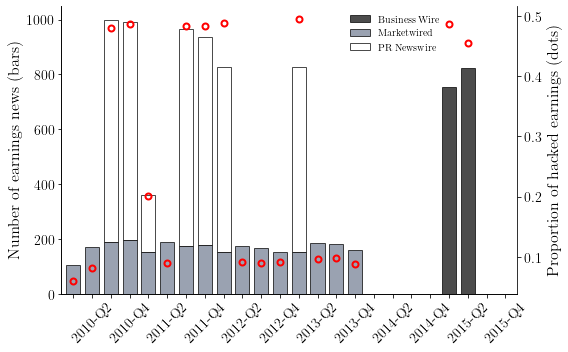

In [61]:
fig, ax = plt.subplots(figsize=(8, 5))
ax1 = df.plot(
    kind="bar",
    width=0.75,
    ax=ax,
    alpha=0.7,
    rot=45,
    stacked=True,
    fontsize=14,
    edgecolor="k",
    colormap="bone",
)
ax2 = n.plot(
    linestyle="",
    ax=ax1,
    secondary_y=True,
    legend=False,
    rot=45,
    fontsize=14,
    color="r",
    marker="o",
    markerfacecolor="none",
    markeredgewidth=2,
)
ticklabels = [""] * len(dates)
ticklabels = [
    str(item.year) + "-Q" + str(item.quarter) for item in dates
]
for x in range(0, len(ticklabels), 2):
    ticklabels[x] = ""
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax1.spines["right"].set_linewidth(0)
ax1.spines["top"].set_linewidth(0)
ax2.spines["top"].set_linewidth(0)

ax2.set_xlabel("")
ax1.set_xlabel("")

ax1.legend(frameon=False, loc="best", bbox_to_anchor=(0.85, 1))
ax1.set_ylabel("Number of earnings news (bars)", fontsize=16)
ax2.set_ylabel("Proportion of hacked earnings (dots)", fontsize=16)

plt.tight_layout()


# Figure 2


In [62]:
df_tmp = ea_df[(ea_df["date"].isin(ea_df[ea_df["actual_updated"] == 1]["date"].values))]
df_tmp["SUE_Med"] = df_tmp["SUE_Med"] * 100
var_list = [
    "lnMCAP",
    "IO",
    "numest",
    "Share_Turn",
    "Option_Turnover",
    "QuotedSpread_Percent",
    "SUE_Med",
    "soft",
]

hacked_mean = df_tmp[df_tmp["hacked"] == 1].groupby(["actual_updated"])[var_list].mean()
hacked_std = df_tmp[df_tmp["hacked"] == 1].groupby(["actual_updated"])[var_list].std()

nonhacked_mean = (
    df_tmp[(df_tmp["hacked"] != 1) & (df_tmp["actual_updated"] != 1)]
    .groupby(["actual_updated"])[var_list]
    .mean()
)

nonhacked_mean = (
    df_tmp[(df_tmp["hacked"] != 1) & (df_tmp["actual_updated"] != 1)]
    .groupby(["actual_updated"])[var_list]
    .std()
)


In [63]:
coeff_actual = []
se_actual = []

coeff_hacked = []
se_hacked = []

coeff_nonhacked = []
se_nonhacked = []

for i in var_list:
    # Actual
    df_tmp2 = df_tmp[(df_tmp["actual_updated"] == 1)]
    reg = smf.ols(i + "~1", data=df_tmp2).fit(cov_type="HC1")
    coeff_actual.append(reg.params["Intercept"])
    se_actual.append(1.96 * reg.bse["Intercept"])

    # hacked not actual
    df_tmp2 = df_tmp[(df_tmp["actual_updated"] != 1) & (df_tmp["hacked"] == 1)]
    reg = smf.ols(i + "~1", data=df_tmp2).fit(cov_type="HC1")
    coeff_hacked.append(reg.params["Intercept"])
    se_hacked.append(1.96 * reg.bse["Intercept"])

    # non-hacked
    df_tmp2 = df_tmp[(df_tmp["actual_updated"] != 1) & (df_tmp["hacked"] != 1)]
    reg = smf.ols(i + "~1", data=df_tmp2).fit(cov_type="HC1")
    coeff_nonhacked.append(reg.params["Intercept"])
    se_nonhacked.append(1.96 * reg.bse["Intercept"])


In [64]:
index_names = [
    "Log MCAP",
    "IO",
    "Analysts",
    "Share turnover",
    "Option turnover",
    "Quoted spreads",
    "Surprise",
    "Soft",
]
all_coeff = pd.DataFrame(
    data={
        "Prosecuted": coeff_actual,
        "Hacked": coeff_hacked,
        "Non-hacked": coeff_nonhacked,
    },
    index=index_names,
)

all_se = pd.DataFrame(
    data={"Prosecuted": se_actual, "Hacked": se_hacked, "Non-hacked": se_nonhacked},
    index=index_names,
)


In [65]:
axes_ = {}
axes_["Log MCAP"] = [0, 0]
axes_["Analysts"] = [0, 1]
axes_["IO"] = [1, 0]
axes_["Quoted spreads"] = [1, 1]
axes_["Share turnover"] = [2, 0]
axes_["Option turnover"] = [2, 1]
axes_["Surprise"] = [3, 0]


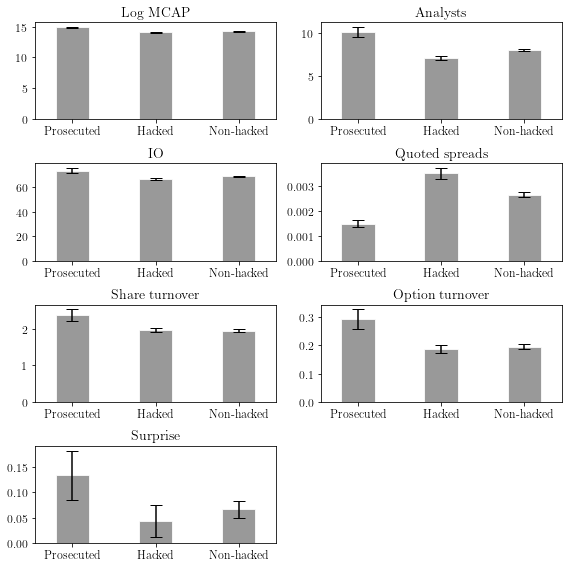

In [66]:
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
for i in [
    "Log MCAP",
    "Analysts",
    "IO",
    "Quoted spreads",
    "Share turnover",
    "Option turnover",
    "Surprise",
]:
    tmp = all_coeff[all_coeff.index == i]
    tmp_se = all_se[all_se.index == i]

    ax = tmp.T.plot.bar(
        yerr=tmp_se.T,
        capsize=6,
        edgecolor="white",
        width=0.4,
        color="grey",
        alpha=0.8,
        fontsize=12,
        rot=0,
        ax=axes[axes_[i][0], axes_[i][1]],
        legend=False,
    )
    ax.set_title(i, fontsize=14)
axes[3, 1].axis("off")
plt.tight_layout()


# Regression functions


In [67]:
def getReg2(
    df,
    model,
    control_var=False,
    control_var_names=False,
    firm_fe=False,
    year_fe=False,
    date_fe=False,
    firm_year_fe=False,
    industry_fe=False,
    firm_date_fe=False,
    cluster_entity_time=False,
    cluster_time=False,
    exclude_other=False,
    matching_fe=False,
    matching_no_fe=False,
    std_var=None,
):

    # standardize variables
    if std_var is not None:
        for var in std_var:
            df[var] = df[var] / df[var].std()
            df[var + "_Hacked"] = df[var] * df["hacked"]

    if exclude_other:
        df = df[df["SOURCE_NAME"] != "OTHER"]

    if control_var:
        control = "+".join(control_var_names)
        model = model + "+" + control
    if year_fe:
        df = df.set_index(["PERMNO", "YYYYQ"])
        model = model + "+TimeEffects"
    elif firm_fe:
        df = df.set_index(["PERMNO", "YYYYQ"])
        model = model + "+EntityEffects"
    elif firm_year_fe:
        df = df.set_index(["PERMNO", "YYYYQ"])
        model = (
            model + "+EntityEffects+TimeEffects"
        )  # minus one is to remove the constant
    elif firm_date_fe:
        df = df.set_index(["PERMNO", "EA_Date"])
        model = (
            model + "+EntityEffects+TimeEffects"
        )  # minus one is to remove the constant
    elif industry_fe:
        df = df.set_index(["gsector", "YYYYQ"])
        model = model + "+EntityEffects+TimeEffects"
    elif matching_fe:
        df = df.set_index(["match_gr", "YYYYQ"])
        model = model + "+EntityEffects"
    elif matching_no_fe:
        df = df.set_index(["match_gr", "YYYYQ"])
    else:
        df = df.set_index(["PERMNO", "EA_Date"])
    # clustering
    if cluster_entity_time:
        reg_ = PanelOLS.from_formula(model, data=df).fit(
            cov_type="clustered", cluster_entity=True, cluster_time=True
        )
    elif cluster_time:
        reg_ = PanelOLS.from_formula(model, data=df).fit(
            cov_type="clustered", cluster_entity=False, cluster_time=True
        )
    else:
        reg_ = PanelOLS.from_formula(model, data=df).fit()
    return reg_


In [68]:
def getTable(reg_, var_names, regressor_order, controls=False):
    all_reg_out = pd.DataFrame()
    for i in reg_.keys():
        res = reg_[i]
        t = pd.concat([res.params, res.std_errors, res.tstats], axis=1)
        star_params = []
        std_err = []
        for p, tstat, std in zip(t["parameter"], t["tstat"], t["std_error"]):
            if np.abs(tstat) >= 1.645 and np.abs(tstat) < 1.96:
                star_params.append("{:.3f}".format(p) + "*")
            elif np.abs(tstat) >= 1.96 and np.abs(tstat) < 2.576:
                star_params.append("{:.3f}".format(p) + "**")
            elif np.abs(tstat) >= 2.576:
                star_params.append("{:.3f}".format(p) + "***")
            else:
                star_params.append("{:.3f}".format(p))
            std_err.append("(" + "{:.3f}".format(std) + ")")
        t["parameter"] = star_params
        t["std_error"] = std_err
        t = t[["parameter", "std_error"]]

        # remove the control variables from the index
        if controls:
            if "lnMCAP" in t.index:
                control_var = True
            else:
                control_var = False
        else:
            control_var = False

        # order the regressors and at the same time keep the ones you want to show
        t = t.loc[regressor_order]

        var_names_index = t.index  # get the parameter names

        output = pd.DataFrame()  # prepare formatting the output table
        for ind in t.index:
            t2 = t.loc[[ind]].T
            t2.index = [ind, ""]
            t2.columns = ["Reg"]
            output = pd.concat([output, t2])
        output.loc["$N$"] = "{0:,d}".format(res.nobs)
        output.loc["$R^2$"] = "{:.3f}".format(res.rsquared)

        # specify if we add control variables:
        if control_var:
            output.loc["Controls"] = "Y"
        else:
            output.loc["Controls"] = "N"
        # add the row specifying fixed effects:
        fe_names = list(
            res.estimated_effects.index.names
        )  # get the names of the fixed-effects
        if res.included_effects == [
            "Time"
        ]:  # must check if we only cluster on time only. If yes, remove first entry
            fe_names = fe_names[1]
        if res.included_effects == [
            "Entity"
        ]:  # must check if we only cluster on time only. If yes, remove first entry
            fe_names = fe_names[0]
        if "YYYYQ" in fe_names:
            output.loc["Year-Quarter F.E."] = "Y"
        else:
            output.loc["Year-Quarter F.E."] = "N"
        if "PERMNO" in fe_names:
            output.loc["Firm F.E."] = "Y"
        else:
            output.loc["Firm F.E."] = "N"
        if "EA_Date" in fe_names:
            output.loc["Date F.E."] = "Y"
        else:
            output.loc["Date F.E."] = "N"
        # rename the index variables
        for names in var_names_index:
            output.rename(
                index={names: var_names[names]}, inplace=True
            )  # change the names for latex
        all_reg_out = pd.concat([all_reg_out, output], axis=1)
    # rename the column header
    ncol = len(all_reg_out.columns) + 1
    all_reg_out.columns = ["(" + str(n) + ")" for n in range(1, ncol)]
    return all_reg_out


In [69]:
def getTableV2(reg_, var_names, regressor_order, table_order, controls=False):
    all_reg_out = pd.DataFrame()
    sse = {}
    i = 0
    for var_ in regressor_order:
        sse[var_] = "se" + str(i)
        i += 1

    for i in reg_.keys():
        res = reg_[i]
        t = pd.concat([res.params, res.std_errors, res.tstats], axis=1)
        star_params = []
        std_err = []
        for p, tstat, std in zip(t["parameter"], t["tstat"], t["std_error"]):
            if np.abs(tstat) >= 1.645 and np.abs(tstat) < 1.96:
                star_params.append("{:.3f}".format(p) + "*")
            elif np.abs(tstat) >= 1.96 and np.abs(tstat) < 2.576:
                star_params.append("{:.3f}".format(p) + "**")
            elif np.abs(tstat) >= 2.576:
                star_params.append("{:.3f}".format(p) + "***")
            else:
                star_params.append("{:.3f}".format(p))
            std_err.append("(" + "{:.3f}".format(std) + ")")
        t["parameter"] = star_params
        t["std_error"] = std_err
        t = t[["parameter", "std_error"]]

        # remove the control variables from the index
        if controls:
            if "lnMCAP" in t.index:
                control_var = True
            else:
                control_var = False
        else:
            control_var = False

        # order the regressors and at the same time keep the ones you want to show
        # t_ = t.loc[regressor_order]

        regressor_order_ = [x for x in regressor_order if x in t.index]
        t_ = t.loc[regressor_order_]

        output = pd.DataFrame()  # prepare formatting the output table

        for ind in t_.index:
            t2 = t_.loc[[ind]].T
            t2.index = [ind, sse[ind]]
            t2.columns = ["Reg"]
            output = pd.concat([output, t2])
        output.loc["N"] = "{0:,d}".format(res.nobs)
        output.loc["R2"] = "{:.3f}".format(res.rsquared)

        # specify if we add control variables:
        if control_var:
            output.loc["Controls"] = "Y"
        else:
            output.loc["Controls"] = "N"
        # add the row specifying fixed effects:
        fe_names = list(
            res.estimated_effects.index.names
        )  # get the names of the fixed-effects
        if res.included_effects == [
            "Time"
        ]:  # must check if we only cluster on time only. If yes, remove first entry
            fe_names = fe_names[1]
        if res.included_effects == [
            "Entity"
        ]:  # must check if we only cluster on time only. If yes, remove first entry
            fe_names = fe_names[0]
        if "YYYYQ" in fe_names:
            output.loc["Year-Quarter F.E."] = "Y"
        else:
            output.loc["Year-Quarter F.E."] = "N"
        if "PERMNO" in fe_names:
            output.loc["Firm F.E."] = "Y"
        else:
            output.loc["Firm F.E."] = "N"
        if "EA_Date" in fe_names:
            output.loc["Date F.E."] = "Y"
        else:
            output.loc["Date F.E."] = "N"

        all_reg_out = pd.concat([all_reg_out, output], axis=1)

    all_reg_out = all_reg_out.loc[table_order]
    # rename the index variables
    var_names_index = all_reg_out.index  # get the parameter names
    for names in var_names_index:
        if names in ["se" + str(i) for i in range(20)]:
            all_reg_out.rename(index={names: ""}, inplace=True)
        try:
            all_reg_out.rename(
                index={names: var_names[names]}, inplace=True
            )  # change the names for latex
        except:
            pass
    # rename the column header
    ncol = len(all_reg_out.columns) + 1
    all_reg_out.columns = ["(" + str(n) + ")" for n in range(1, ncol)]
    return all_reg_out


In [70]:
var_names = {
    "Intercept": "Intercept",
    "N": "$N$",
    "R2": "$R^2$",
    "SUE_Med": "$Surprise$",
    "SUE_Med2": "$Surprise$",
    "SUE_Med_Hacked": "$Surprise\\times\\mathbf{1}_{[\\text{Hacked}]}$",
    "soft": "$Soft$",
    "soft_Hacked": "$Soft\\times\\mathbf{1}_{[\\text{Hacked}]}$",
    "hacked": "$\\mathbf{1}_{[\\text{Hacked}]}$",
    "lnMCAP": "$Ln MCAP$",
    "LRET": "$Log\;Return$",
    "LRet": "$Log\;Return$",
    "LRet_12pm_Close": "$Return^{12-4PM}$",
    "LRet_12pm_Close_Hacked": "$Return^{12-4PM}\\times\\mathbf{1}_{[\\text{Hacked}]}$",
    "LRET_Hacked": "$Log\;Return \\times\\mathbf{1}_{[\\text{Hacked}]}$",
    "SUE_Med_Actual": "$Surprise\\times\\mathbf{1}_{[\\text{Traded}]}$",
    "SUE_Med_Hacked_Actual": "$Surprise\\times\\mathbf{1}_{[\\text{Hacked}]}\\times\\mathbf{1}_{[\\text{Traded}]}$",
}


# Table 1


## Panel A


In [71]:
des = ea_df[
    [
        "SUE_Med",
        "SUE_Med_abs",
        "lnMCAP",
        "IO",
        "numest",
        "lnQvalue",
        "Share_Turn",
        "Option_Turnover",
    ]
].describe()
des = des.loc[["mean", "50%", "std", "count"]]
des.columns = [
    "Surprise",
    "$|$Surprise$|$",
    "Ln MCAP",
    "IO",
    "N. analysts",
    "Ln Q-value",
    "Share turn.",
    "Option turn.",
]
des.index = ["Mean", "Median", "Std. dev.", "N"]
des = des.round(decimals=4)
des["IO"] = np.round(des["IO"], 2)
des["N. analysts"] = np.round(des["N. analysts"], 2)
des["Ln MCAP"] = np.round(des["Ln MCAP"], 2)
des["Share turn."] = np.round(des["Share turn."], 2)
des["Option turn."] = np.round(des["Option turn."], 2)
des["Ln Q-value"] = np.round(des["Ln Q-value"], 2)
des.loc["N"] = ["{0:,d}".format(int(i)) for i in des.loc["N"]]
des


,Surprise,$|$Surprise$|$,Ln MCAP,IO,N. analysts,Ln Q-value,Share turn.,Option turn.
Mean,0.0004,0.007,14.16,68.37,7.69,0.97,1.99,0.2
Median,0.0006,0.0017,14.1,77.53,5.0,0.8,1.46,0.04
Std. dev.,0.0104,0.0373,1.77,28.82,6.92,1.53,2.11,0.47
N,"43,687","43,687","43,687","43,687","43,687","35,273","43,687","43,687"


## Panel B

Characteristic regression


In [72]:
dep_var = [
    "SUE_Med",
    "SUE_Med_abs",
    "lnMCAP",
    "IO",
    "numest",
    "lnQvalue",
    "Share_Turn",
    "Option_Turnover",
]
reg = {}
i = 0
for dep in dep_var:
    reg_model = dep + "~hacked"
    reg[i] = getReg2(ea_df, reg_model, year_fe=True, cluster_entity_time=True)
    i += 1


In [73]:
tab = getTable(reg, var_names, regressor_order=["hacked"], controls=True)
tab.columns = [
    [
        "Surprise",
        "$|$Surprise$|$",
        "Ln MCAP",
        "IO",
        "N. analysts",
        "Ln Q-value",
        "Share turn.",
        "Option turn.",
    ],
    tab.columns,
]
tab = tab.drop(["Controls", "Date F.E."])


In [74]:
tab


,Surprise,$|$Surprise$|$,Ln MCAP,IO,N. analysts,Ln Q-value,Share turn.,Option turn.
,(1),(2),(3),(4),(5),(6),(7),(8)
$\mathbf{1}_{[\text{Hacked}]}$,-0.000,0.000,-0.195**,-3.119**,-0.153,0.045,0.051,0.003
,(0.000),(0.001),(0.079),(1.336),(0.221),(0.055),(0.061),(0.014)
$N$,"43,687","43,687","43,687","43,687","43,687","35,273","43,687","43,687"
$R^2$,0.000,0.000,0.002,0.001,0.000,0.000,0.000,0.000
Year-Quarter F.E.,Y,Y,Y,Y,Y,Y,Y,Y
Firm F.E.,N,N,N,N,N,N,N,N


## Panel C

Firm and year FE


In [75]:
dep_var = [
    "SUE_Med",
    "SUE_Med_abs",
    "lnMCAP",
    "IO",
    "numest",
    "lnQvalue",
    "Share_Turn",
    "Option_Turnover",
]
reg = {}
i = 0
for dep in dep_var:
    reg_model = dep + "~hacked"
    reg[i] = getReg2(ea_df, reg_model, firm_year_fe=True, cluster_entity_time=True)
    i += 1


In [76]:
tab = getTable(reg, var_names, regressor_order=["hacked"], controls=True)
tab.columns = [
    [
        "Surprise",
        "$|$Surprise$|$",
        "Ln MCAP",
        "IO",
        "N. analysts",
        "Ln Q-value",
        "Share turn.",
        "Option turn.",
    ],
    tab.columns,
]
tab = tab.drop(["Controls", "Date F.E."])


In [77]:
tab


,Surprise,$|$Surprise$|$,Ln MCAP,IO,N. analysts,Ln Q-value,Share turn.,Option turn.
,(1),(2),(3),(4),(5),(6),(7),(8)
$\mathbf{1}_{[\text{Hacked}]}$,0.000,-0.000,0.002,0.084,0.088,-0.021,-0.010,-0.004
,(0.000),(0.001),(0.011),(0.293),(0.078),(0.019),(0.032),(0.006)
$N$,"43,687","43,687","43,687","43,687","43,687","35,273","43,687","43,687"
$R^2$,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Year-Quarter F.E.,Y,Y,Y,Y,Y,Y,Y,Y
Firm F.E.,Y,Y,Y,Y,Y,Y,Y,Y


# Table 2


## Panel A

Heatmap


In [78]:
ea_df_ = ea_df[ea_df["soft"].notnull()]

news = ea_df_[["soft", "SUE_Med", "SUE_Med_qnt", "soft_qnt", "AH_Ret"]]
heat = news.groupby(["SUE_Med_qnt", "soft_qnt"])[["AH_Ret"]].mean().reset_index()
heat.columns = ["Surprise", "Soft", "After-hours return"]
heat["Soft"] = heat["Soft"].astype(int)
heat = heat.pivot(index="Surprise", columns="Soft", values="After-hours return")
heat.index = range(1, 6)
heat.columns = range(1, 6)


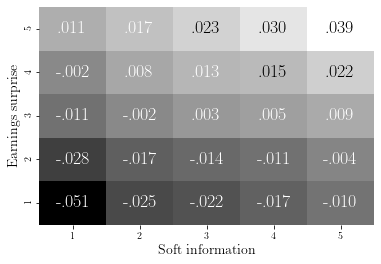

In [79]:
plt.figure(figsize=(6, 4))
ax1 = sns.heatmap(heat, cmap=cm.gray, label="big", cbar=False)  # cmap='coolwarm'
for i in range(len(heat)):
    for j in range(len(heat)):
        if (
            (i == 3 and j == 3)
            or (i == 3 and j == 4)
            or (i == 4 and j == 3)
            or (i == 4 and j == 4)
            or (i == 4 and j == 2)
        ):
            text = ax1.text(
                j + 0.5,
                i + 0.5,
                "{:.3f}".format(heat.iloc[i, j]).replace("0.", ".").replace("nan", ""),
                ha="center",
                va="center",
                color="k",
                fontsize=18,
                weight="bold",
            )
        else:
            text = ax1.text(
                j + 0.5,
                i + 0.5,
                "{:.3f}".format(heat.iloc[i, j]).replace("0.", ".").replace("nan", ""),
                ha="center",
                va="center",
                color="w",
                fontsize=18,
                weight="bold",
            )
ax1.set_ylabel("Earnings surprise", fontsize=14)
ax1.set_xlabel("Soft information", fontsize=14)
ax1.invert_yaxis()


## Panel B


In [80]:
reg = {}

model = "AH_Ret~1+SUE_Med"
reg[0] = getReg2(ea_df, model, cluster_entity_time=True)

model = "AH_Ret~1+soft"
reg[1] = getReg2(ea_df_, model, cluster_entity_time=True)

model = "AH_Ret~1+SUE_Med+soft"
reg[2] = getReg2(ea_df_, model, cluster_entity_time=True)


In [81]:
tab = getTableV2(
    reg,
    var_names,
    regressor_order=["SUE_Med", "soft", "Intercept"],
    table_order=[
        "SUE_Med",
        "se0",
        "soft",
        "se1",
        "Intercept",
        "se2",
        "N",
        "R2",
        "Controls",
        "Year-Quarter F.E.",
        "Firm F.E.",
    ],
)
tab = tab[:-3]
tab


,(1),(2),(3)
$Surprise$,1.313***,NaN,1.184***
,(0.048),NaN,(0.051)
$Soft$,NaN,1.201***,1.047***
,NaN,(0.036),(0.035)
Intercept,-0.002***,-0.002***,-0.003***
,(0.000),(0.000),(0.000)
$N$,"43,687","36,750","36,750"
$R^2$,0.061,0.068,0.115


# Table 3


## Panel A


In [82]:
reg_model = "AH_Ret~SUE_Med+hacked+SUE_Med_Hacked"
reg = {}

reg[0] = getReg2(ea_df, reg_model, year_fe=True, cluster_entity_time=True)
reg[1] = getReg2(ea_df, reg_model, firm_year_fe=True, cluster_entity_time=True)
reg[2] = getReg2(
    ea_df,
    reg_model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_year_fe=True,
    cluster_entity_time=True,
)
reg[3] = getReg2(
    ea_df,
    reg_model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_date_fe=True,
    cluster_entity_time=True,
)


In [83]:
tab = getTable(
    reg,
    var_names,
    regressor_order=["SUE_Med", "SUE_Med_Hacked", "hacked"],
    controls=True,
)


In [84]:
tab


,(1),(2),(3),(4)
$Surprise$,1.364***,1.436***,1.443***,1.426***
,(0.073),(0.079),(0.079),(0.062)
$Surprise\times\mathbf{1}_{[\text{Hacked}]}$,-0.212**,-0.234**,-0.241**,-0.215**
,(0.103),(0.103),(0.104),(0.101)
$\mathbf{1}_{[\text{Hacked}]}$,-0.001,-0.001,-0.001,-0.000
,(0.001),(0.001),(0.001),(0.001)
$N$,"43,687","43,687","43,687","43,687"
$R^2$,0.062,0.060,0.071,0.067
Controls,N,N,Y,Y
Year-Quarter F.E.,Y,Y,Y,N


## Panel B


In [85]:
ea_df_ = ea_df[ea_df["soft"].notnull()]

reg_model = "AH_Ret~soft+hacked+soft_Hacked"
reg = {}

reg[0] = getReg2(ea_df_, reg_model, year_fe=True, cluster_entity_time=True)
reg[1] = getReg2(ea_df_, reg_model, firm_year_fe=True, cluster_entity_time=True)
reg[2] = getReg2(
    ea_df_,
    reg_model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_year_fe=True,
    cluster_entity_time=True,
)
reg[3] = getReg2(
    ea_df_,
    reg_model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_date_fe=True,
    cluster_entity_time=True,
)


In [86]:
tab = getTable(
    reg, var_names, regressor_order=["soft", "soft_Hacked", "hacked"], controls=True
)
tab


,(1),(2),(3),(4)
$Soft$,1.246***,1.352***,1.345***,1.334***
,(0.062),(0.065),(0.063),(0.045)
$Soft\times\mathbf{1}_{[\text{Hacked}]}$,-0.184*,-0.220**,-0.222**,-0.210**
,(0.097),(0.099),(0.100),(0.083)
$\mathbf{1}_{[\text{Hacked}]}$,-0.001,-0.001,-0.001,-0.001
,(0.001),(0.001),(0.001),(0.001)
$N$,"36,750","36,750","36,750","36,750"
$R^2$,0.069,0.062,0.072,0.068
Controls,N,N,Y,Y
Year-Quarter F.E.,Y,Y,Y,N


## Panel C


In [87]:
reg = {}
reg_model = "AH_Ret~soft+hacked+soft_Hacked+SUE_Med+SUE_Med_Hacked"

reg[0] = getReg2(ea_df_, reg_model, year_fe=True, cluster_entity_time=True)
reg[1] = getReg2(ea_df_, reg_model, firm_year_fe=True, cluster_entity_time=True)
reg[2] = getReg2(
    ea_df_,
    reg_model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_year_fe=True,
    cluster_entity_time=True,
)
reg[3] = getReg2(
    ea_df_,
    reg_model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_date_fe=True,
    cluster_entity_time=True,
)
tab = getTable(
    reg,
    var_names,
    regressor_order=["SUE_Med", "soft", "SUE_Med_Hacked", "soft_Hacked", "hacked"],
    controls=True,
)
tab


,(1),(2),(3),(4)
$Surprise$,1.225***,1.326***,1.336***,1.308***
,(0.071),(0.081),(0.081),(0.064)
$Soft$,1.090***,1.192***,1.183***,1.176***
,(0.060),(0.060),(0.059),(0.042)
$Surprise\times\mathbf{1}_{[\text{Hacked}]}$,-0.174,-0.199*,-0.207*,-0.144
,(0.111),(0.111),(0.112),(0.113)
$Soft\times\mathbf{1}_{[\text{Hacked}]}$,-0.179**,-0.202**,-0.202**,-0.193**
,(0.088),(0.091),(0.092),(0.080)
$\mathbf{1}_{[\text{Hacked}]}$,-0.001,-0.001,-0.001,-0.001
,(0.001),(0.001),(0.001),(0.001)


# Table 4


In [88]:
reg = {}

reg_model = "LRet_12pm_OpenNext~LRet_12pm_Close+LRet_12pm_Close_Hacked+hacked"
reg[0] = getReg2(
    ea_df,
    reg_model,
    control_var=True,
    control_var_names=[
        "lnMCAP",
        "Day_Beta_SPY_LRet_12pm_OpenNext",
    ],  # , 'Day_Beta_SPY_'+dep
    firm_year_fe=True,
    cluster_entity_time=True,
)

reg_model = "LRet_12pm_CloseNext~LRet_12pm_Close+LRet_12pm_Close_Hacked+hacked"
reg[1] = getReg2(
    ea_df,
    reg_model,
    control_var=True,
    control_var_names=[
        "lnMCAP",
        "Day_Beta_SPY_LRet_12pm_CloseNext",
    ],  # , 'Day_Beta_SPY_'+dep
    firm_year_fe=True,
    cluster_entity_time=True,
)


In [89]:
tab = getTable(
    reg,
    var_names,
    regressor_order=["LRet_12pm_Close", "LRet_12pm_Close_Hacked", "hacked"],
    controls=True,
)
tab.drop("Date F.E.", inplace=True)
tab.columns = [
    ["Dependant variable return window", ""],
    ["12 p.m.(t)-9:30 a.m.(t+1)", "12 p.m.(t)-4 p.m.(t+1)"],
    ["(1)", "(2)"],
]
tab


,Dependant variable return window,
,12 p.m.(t)-9:30 a.m.(t+1),12 p.m.(t)-4 p.m.(t+1)
,(1),(2)
$Return^{12-4PM}$,0.776***,0.591***
,(0.029),(0.038)
$Return^{12-4PM}\times\mathbf{1}_{[\text{Hacked}]}$,0.130***,0.142**
,(0.044),(0.059)
$\mathbf{1}_{[\text{Hacked}]}$,-0.001,-0.001
,(0.001),(0.001)
$N$,"43,687","43,687"
$R^2$,0.082,0.057


## Table 5


In [90]:
ea_df_ = ea_df[ea_df["soft"].notnull()]
ea_df_["soft_abs_cut"] = pd.qcut(ea_df_["soft_abs"], 4, labels=False)


In [91]:
ea_df_["SUE_Med_abs_cut"] = pd.qcut(ea_df_["SUE_Med_abs"], 4, labels=False)


## Panel A


In [92]:
ea_df_low = ea_df_[ea_df_["soft_abs_cut"].isin([0, 1])]
ea_df_high = ea_df_[ea_df_["soft_abs_cut"].isin([2, 3])]

model = "AH_Ret~SUE_Med+SUE_Med_Hacked+hacked"

reg = {}
reg[0] = getReg2(
    ea_df_high, model, control_var=False, firm_year_fe=True, cluster_entity_time=True
)
reg[1] = getReg2(
    ea_df_high,
    model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_year_fe=True,
    cluster_entity_time=True,
)

reg[2] = getReg2(
    ea_df_low, model, control_var=False, firm_year_fe=True, cluster_entity_time=True
)
reg[3] = getReg2(
    ea_df_low,
    model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_year_fe=True,
    cluster_entity_time=True,
)


In [93]:
tab = getTable(
    reg,
    var_names,
    regressor_order=["SUE_Med", "SUE_Med_Hacked", "hacked"],
    controls=True,
)
tab = tab.drop("Date F.E.")
tab.columns = [["High $|\text{soft}|$", "", "Low $|\text{soft}|$", ""], tab.columns]
tab


,High $|\text{soft}|$,,Low $|\text{soft}|$,
,(1),(2),(3),(4)
$Surprise$,1.759***,1.763***,1.291***,1.314***
,(0.119),(0.119),(0.108),(0.107)
$Surprise\times\mathbf{1}_{[\text{Hacked}]}$,-0.334**,-0.329**,-0.215,-0.245
,(0.164),(0.162),(0.150),(0.153)
$\mathbf{1}_{[\text{Hacked}]}$,-0.001,-0.001,-0.001,-0.001
,(0.002),(0.001),(0.001),(0.001)
$N$,"18,375","18,375","18,375","18,375"
$R^2$,0.076,0.087,0.048,0.061
Controls,N,Y,N,Y


## Panel B


In [94]:
ea_df_low = ea_df_[ea_df_["SUE_Med_abs_cut"].isin([0, 1])]
ea_df_high = ea_df_[ea_df_["SUE_Med_abs_cut"].isin([2, 3])]

model = "AH_Ret~soft+soft_Hacked+hacked"

reg = {}
reg[0] = getReg2(
    ea_df_high, model, control_var=False, firm_year_fe=True, cluster_entity_time=True
)
reg[1] = getReg2(
    ea_df_high,
    model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_year_fe=True,
    cluster_entity_time=True,
)

reg[2] = getReg2(
    ea_df_low, model, control_var=False, firm_year_fe=True, cluster_entity_time=True
)
reg[3] = getReg2(
    ea_df_low,
    model,
    control_var=True,
    control_var_names=["lnMCAP", "Beta_SPY_Overnight_RET"],
    firm_year_fe=True,
    cluster_entity_time=True,
)


In [95]:
tab = getTable(
    reg, var_names, regressor_order=["soft", "soft_Hacked", "hacked"], controls=True
)
tab = tab.drop("Date F.E.")
tab.columns = [
    ["High $|\text{surprise}|$", "", "Low $|\text{surprise}|$", ""],
    tab.columns,
]
tab


,High $|\text{surprise}|$,,Low $|\text{surprise}|$,
,(1),(2),(3),(4)
$Soft$,1.638***,1.630***,0.934***,0.925***
,(0.091),(0.090),(0.058),(0.058)
$Soft\times\mathbf{1}_{[\text{Hacked}]}$,-0.336**,-0.333**,-0.126,-0.134
,(0.131),(0.131),(0.122),(0.123)
$\mathbf{1}_{[\text{Hacked}]}$,-0.001,-0.001,0.000,0.000
,(0.002),(0.002),(0.001),(0.001)
$N$,"18,375","18,375","18,375","18,375"
$R^2$,0.079,0.084,0.037,0.064
Controls,N,Y,N,Y


# Figure 4


In [96]:
df_tmp = ea_df_[
    (ea_df_["date"].isin(ea_df_[ea_df_["actual_updated"] == 1]["date"].values))
]
df_tmp["SUE_Med_qnt"] = pd.qcut(df_tmp["SUE_Med"], 5, labels=False)
df_tmp["soft_qnt"] = pd.qcut(df_tmp["soft"], 5, labels=False)

df_tmp["SUE_Med_qnt"] = df_tmp["SUE_Med_qnt"].astype(int)
df_tmp["soft_qnt"] = df_tmp["soft_qnt"].astype(int)


In [97]:
hacked_tmp = (
    df_tmp[df_tmp["hacked"] == 1]
    .groupby(["actual_updated", "SUE_Med_qnt"])[["soft"]]
    .mean()
    .reset_index()
    .pivot(columns="actual_updated", index="SUE_Med_qnt", values="soft")
)
nonhacked_tmp = (
    df_tmp[(df_tmp["hacked"] != 1) & (df_tmp["actual_updated"] != 1)]
    .groupby(["actual_updated", "SUE_Med_qnt"])[["soft"]]
    .mean()
    .reset_index()
    .pivot(columns="actual_updated", index="SUE_Med_qnt", values="soft")
)


In [98]:
se_all = []
for i in range(5):
    # Non hacked
    df_tmp2 = df_tmp[(df_tmp["SUE_Med_qnt"] == i) & (df_tmp["hacked"] != 1)]
    reg = smf.ols("soft~1", data=df_tmp2).fit(cov_type="HC1")
    se_all.append(1.96 * reg.bse["Intercept"])
    # hacked not actual
    df_tmp2 = df_tmp[
        (df_tmp["SUE_Med_qnt"] == i)
        & (df_tmp["hacked"] == 1)
        & (df_tmp["actual_updated"] != 1)
    ]
    reg = smf.ols("soft~1", data=df_tmp2).fit(cov_type="HC1")
    se_all.append(1.96 * reg.bse["Intercept"])
    # hacked not actual
    df_tmp2 = df_tmp[
        (df_tmp["SUE_Med_qnt"] == i)
        & (df_tmp["hacked"] == 1)
        & (df_tmp["actual_updated"] == 1)
    ]
    reg = smf.ols("soft~1", data=df_tmp2).fit(cov_type="HC1")
    se_all.append(1.96 * reg.bse["Intercept"])


## Panel A


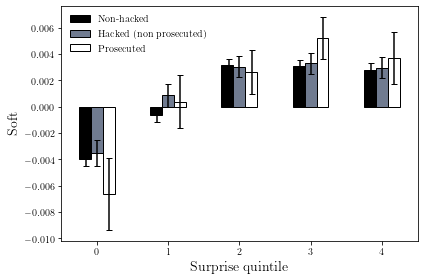

In [99]:
tmp2 = pd.concat([hacked_tmp, nonhacked_tmp], axis=1)
tmp2.columns = ["Hacked", "Prosecuted", "Non-hacked"]
tmp2 = tmp2[["Non-hacked", "Hacked", "Prosecuted"]]
tmp2.index.names = ["Surprise quintile"]

ax = tmp2.plot(kind="bar", colormap="bone", edgecolor="k", rot=360)
ax.set_ylabel("Soft", fontsize=14)
ax.set_xlabel("Surprise quintile", fontsize=14)

ax.legend(["Non-hacked", "Hacked (non prosecuted)", "Prosecuted"], frameon=False)
ax.errorbar(
    -0.15,
    tmp2["Non-hacked"].loc[0],
    yerr=se_all[0],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    0, tmp2["Hacked"].loc[0], yerr=se_all[1], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    0.175,
    tmp2["Prosecuted"].loc[0],
    yerr=se_all[2],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    0.85, tmp2["Non-hacked"].loc[1], yerr=se_all[3], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    1, tmp2["Hacked"].loc[1], yerr=se_all[4], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    1.175,
    tmp2["Prosecuted"].loc[1],
    yerr=se_all[5],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    1.85, tmp2["Non-hacked"].loc[2], yerr=se_all[6], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    2, tmp2["Hacked"].loc[2], yerr=se_all[7], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    2.175,
    tmp2["Prosecuted"].loc[2],
    yerr=se_all[8],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    2.85, tmp2["Non-hacked"].loc[3], yerr=se_all[9], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    3, tmp2["Hacked"].loc[3], yerr=se_all[10], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    3.175,
    tmp2["Prosecuted"].loc[3],
    yerr=se_all[11],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    3.85,
    tmp2["Non-hacked"].loc[4],
    yerr=se_all[12],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    4, tmp2["Hacked"].loc[4], yerr=se_all[13], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    4.175,
    tmp2["Prosecuted"].loc[4],
    yerr=se_all[14],
    color="k",
    linewidth=1.5,
    capsize=3,
)
plt.tight_layout()


## Panel B


In [100]:
hacked_tmp = (
    df_tmp[df_tmp["hacked"] == 1]
    .groupby(["actual_updated", "soft_qnt"])[["SUE_Med"]]
    .mean()
    .reset_index()
    .pivot(columns="actual_updated", index="soft_qnt", values="SUE_Med")
)
nonhacked_tmp = (
    df_tmp[(df_tmp["hacked"] != 1) & (df_tmp["actual_updated"] != 1)]
    .groupby(["actual_updated", "soft_qnt"])[["SUE_Med"]]
    .mean()
    .reset_index()
    .pivot(columns="actual_updated", index="soft_qnt", values="SUE_Med")
)


In [101]:
se_all = []

for i in range(5):
    # Non hacked
    df_tmp2 = df_tmp[(df_tmp["soft_qnt"] == i) & (df_tmp["hacked"] != 1)]
    reg = smf.ols("SUE_Med~1", data=df_tmp2).fit(cov_type="HC1")
    se_all.append(1.96 * reg.bse["Intercept"])
    # hacked not actual
    df_tmp2 = df_tmp[
        (df_tmp["soft_qnt"] == i)
        & (df_tmp["hacked"] == 1)
        & (df_tmp["actual_updated"] != 1)
    ]
    reg = smf.ols("SUE_Med~1", data=df_tmp2).fit(cov_type="HC1")
    se_all.append(1.96 * reg.bse["Intercept"])
    # hacked not actual
    df_tmp2 = df_tmp[
        (df_tmp["soft_qnt"] == i)
        & (df_tmp["hacked"] == 1)
        & (df_tmp["actual_updated"] == 1)
    ]
    reg = smf.ols("SUE_Med~1", data=df_tmp2).fit(cov_type="HC1")
    se_all.append(1.96 * reg.bse["Intercept"])


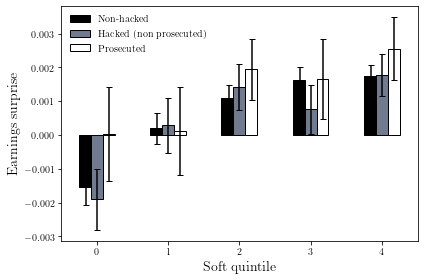

In [102]:
tmp2 = pd.concat([hacked_tmp, nonhacked_tmp], axis=1)
tmp2.columns = ["Hacked", "Prosecuted", "Non-hacked"]
tmp2 = tmp2[["Non-hacked", "Hacked", "Prosecuted"]]
tmp2.index.names = ["Soft info quintile"]

ax = tmp2.plot(kind="bar", colormap="bone", edgecolor="k", rot=360)
ax.set_ylabel("Earnings surprise", fontsize=14)
ax.set_xlabel("Soft quintile", fontsize=14)

ax.legend(["Non-hacked", "Hacked (non prosecuted)", "Prosecuted"], frameon=False)
ax.errorbar(
    -0.15,
    tmp2["Non-hacked"].loc[0],
    yerr=se_all[0],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    0, tmp2["Hacked"].loc[0], yerr=se_all[1], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    0.175,
    tmp2["Prosecuted"].loc[0],
    yerr=se_all[2],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    0.85, tmp2["Non-hacked"].loc[1], yerr=se_all[3], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    1, tmp2["Hacked"].loc[1], yerr=se_all[4], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    1.175,
    tmp2["Prosecuted"].loc[1],
    yerr=se_all[5],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    1.85, tmp2["Non-hacked"].loc[2], yerr=se_all[6], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    2, tmp2["Hacked"].loc[2], yerr=se_all[7], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    2.175,
    tmp2["Prosecuted"].loc[2],
    yerr=se_all[8],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    2.85, tmp2["Non-hacked"].loc[3], yerr=se_all[9], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    3, tmp2["Hacked"].loc[3], yerr=se_all[10], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    3.175,
    tmp2["Prosecuted"].loc[3],
    yerr=se_all[11],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    3.85,
    tmp2["Non-hacked"].loc[4],
    yerr=se_all[12],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    4, tmp2["Hacked"].loc[4], yerr=se_all[13], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    4.175,
    tmp2["Prosecuted"].loc[4],
    yerr=se_all[14],
    color="k",
    linewidth=1.5,
    capsize=3,
)

plt.tight_layout()


## Panel C


In [103]:
hacked_tmp = (
    df_tmp[df_tmp["hacked"] == 1]
    .groupby(["actual_updated", "SUE_Med_qnt"])[["LRet_12pm_OpenNext"]]
    .mean()
    .reset_index()
    .pivot(columns="actual_updated", index="SUE_Med_qnt", values="LRet_12pm_OpenNext")
)
nonhacked_tmp = (
    df_tmp[(df_tmp["hacked"] != 1) & (df_tmp["actual_updated"] != 1)]
    .groupby(["actual_updated", "SUE_Med_qnt"])[["LRet_12pm_OpenNext"]]
    .mean()
    .reset_index()
    .pivot(columns="actual_updated", index="SUE_Med_qnt", values="LRet_12pm_OpenNext")
)


In [104]:
se_sue_ret = []

for i in range(5):
    # Non hacked
    df_tmp2 = df_tmp[(df_tmp["SUE_Med_qnt"] == i) & (df_tmp["hacked"] != 1)]
    reg = smf.ols("LRet_12pm_OpenNext~1", data=df_tmp2).fit(cov_type="HC1")
    se_sue_ret.append(1.96 * reg.bse["Intercept"])
    # hacked not actual
    df_tmp2 = df_tmp[
        (df_tmp["SUE_Med_qnt"] == i)
        & (df_tmp["hacked"] == 1)
        & (df_tmp["actual_updated"] != 1)
    ]
    reg = smf.ols("LRet_12pm_OpenNext~1", data=df_tmp2).fit(cov_type="HC1")
    se_sue_ret.append(1.96 * reg.bse["Intercept"])
    # hacked not actual
    df_tmp2 = df_tmp[
        (df_tmp["SUE_Med_qnt"] == i)
        & (df_tmp["hacked"] == 1)
        & (df_tmp["actual_updated"] == 1)
    ]
    reg = smf.ols("LRet_12pm_OpenNext~1", data=df_tmp2).fit(cov_type="HC1")
    se_sue_ret.append(1.96 * reg.bse["Intercept"])


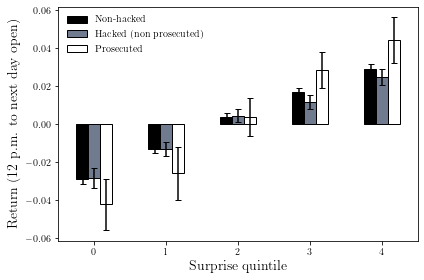

In [105]:
sue_ret = pd.concat([hacked_tmp, nonhacked_tmp], axis=1)
sue_ret.columns = ["Hacked", "Prosecuted", "Non-hacked"]
sue_ret = sue_ret[["Non-hacked", "Hacked", "Prosecuted"]]
sue_ret.index.names = ["Surprise quintile"]

ax = sue_ret.plot(kind="bar", colormap="bone", edgecolor="k", rot=360)
ax.set_ylabel("Return (12 p.m. to next day open)", fontsize=14)
ax.set_xlabel("Surprise quintile", fontsize=14)

ax.legend(["Non-hacked", "Hacked (non prosecuted)", "Prosecuted"], frameon=False)
ax.errorbar(
    -0.15,
    sue_ret["Non-hacked"].loc[0],
    yerr=se_sue_ret[0],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    0, sue_ret["Hacked"].loc[0], yerr=se_sue_ret[1], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    0.175,
    sue_ret["Prosecuted"].loc[0],
    yerr=se_sue_ret[2],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    0.85,
    sue_ret["Non-hacked"].loc[1],
    yerr=se_sue_ret[3],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    1, sue_ret["Hacked"].loc[1], yerr=se_sue_ret[4], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    1.175,
    sue_ret["Prosecuted"].loc[1],
    yerr=se_sue_ret[5],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    1.85,
    sue_ret["Non-hacked"].loc[2],
    yerr=se_sue_ret[6],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    2, sue_ret["Hacked"].loc[2], yerr=se_sue_ret[7], color="k", linewidth=1.5, capsize=3
)
ax.errorbar(
    2.175,
    sue_ret["Prosecuted"].loc[2],
    yerr=se_sue_ret[8],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    2.85,
    sue_ret["Non-hacked"].loc[3],
    yerr=se_sue_ret[9],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    3,
    sue_ret["Hacked"].loc[3],
    yerr=se_sue_ret[10],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    3.175,
    sue_ret["Prosecuted"].loc[3],
    yerr=se_sue_ret[11],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    3.85,
    sue_ret["Non-hacked"].loc[4],
    yerr=se_sue_ret[12],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    4,
    sue_ret["Hacked"].loc[4],
    yerr=se_sue_ret[13],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    4.175,
    sue_ret["Prosecuted"].loc[4],
    yerr=se_sue_ret[14],
    color="k",
    linewidth=1.5,
    capsize=3,
)


plt.tight_layout()


## Panel D


In [106]:
hacked_tmp = (
    df_tmp[df_tmp["hacked"] == 1]
    .groupby(["actual_updated", "soft_qnt"])[["LRet_12pm_OpenNext"]]
    .mean()
    .reset_index()
    .pivot(columns="actual_updated", index="soft_qnt", values="LRet_12pm_OpenNext")
)
nonhacked_tmp = (
    df_tmp[(df_tmp["hacked"] != 1) & (df_tmp["actual_updated"] != 1)]
    .groupby(["actual_updated", "soft_qnt"])[["LRet_12pm_OpenNext"]]
    .mean()
    .reset_index()
    .pivot(columns="actual_updated", index="soft_qnt", values="LRet_12pm_OpenNext")
)


In [107]:
se_soft_ret = []

for i in range(5):
    # Non hacked
    df_tmp2 = df_tmp[(df_tmp["soft_qnt"] == i) & (df_tmp["hacked"] != 1)]
    reg = smf.ols("LRet_12pm_OpenNext~1", data=df_tmp2).fit(cov_type="HC1")
    se_soft_ret.append(1.96 * reg.bse["Intercept"])
    # hacked not actual
    df_tmp2 = df_tmp[
        (df_tmp["soft_qnt"] == i)
        & (df_tmp["hacked"] == 1)
        & (df_tmp["actual_updated"] != 1)
    ]
    reg = smf.ols("LRet_12pm_OpenNext~1", data=df_tmp2).fit(cov_type="HC1")
    se_soft_ret.append(1.96 * reg.bse["Intercept"])
    # hacked not actual
    df_tmp2 = df_tmp[
        (df_tmp["soft_qnt"] == i)
        & (df_tmp["hacked"] == 1)
        & (df_tmp["actual_updated"] == 1)
    ]
    reg = smf.ols("LRet_12pm_OpenNext~1", data=df_tmp2).fit(cov_type="HC1")
    se_soft_ret.append(1.96 * reg.bse["Intercept"])


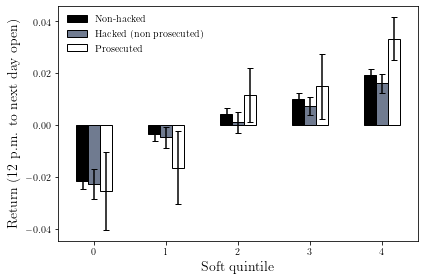

In [108]:
soft_ret = pd.concat([hacked_tmp, nonhacked_tmp], axis=1)
soft_ret.columns = ["Hacked", "Prosecuted", "Non-hacked"]
soft_ret = soft_ret[["Non-hacked", "Hacked", "Prosecuted"]]
soft_ret.index.names = ["Soft info quintile"]

ax = soft_ret.plot(kind="bar", colormap="bone", edgecolor="k", rot=360)
ax.set_ylabel("Return (12 p.m. to next day open)", fontsize=14)
ax.set_xlabel("Soft quintile", fontsize=14)
ax.legend(["Non-hacked", "Hacked (non prosecuted)", "Prosecuted"], frameon=False)
ax.errorbar(
    -0.15,
    soft_ret["Non-hacked"].loc[0],
    yerr=se_soft_ret[0],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    0,
    soft_ret["Hacked"].loc[0],
    yerr=se_soft_ret[1],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    0.175,
    soft_ret["Prosecuted"].loc[0],
    yerr=se_soft_ret[2],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    0.85,
    soft_ret["Non-hacked"].loc[1],
    yerr=se_soft_ret[3],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    1,
    soft_ret["Hacked"].loc[1],
    yerr=se_soft_ret[4],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    1.175,
    soft_ret["Prosecuted"].loc[1],
    yerr=se_soft_ret[5],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    1.85,
    soft_ret["Non-hacked"].loc[2],
    yerr=se_soft_ret[6],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    2,
    soft_ret["Hacked"].loc[2],
    yerr=se_soft_ret[7],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    2.175,
    soft_ret["Prosecuted"].loc[2],
    yerr=se_soft_ret[8],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    2.85,
    soft_ret["Non-hacked"].loc[3],
    yerr=se_soft_ret[9],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    3,
    soft_ret["Hacked"].loc[3],
    yerr=se_soft_ret[10],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    3.175,
    soft_ret["Prosecuted"].loc[3],
    yerr=se_soft_ret[11],
    color="k",
    linewidth=1.5,
    capsize=3,
)

ax.errorbar(
    3.85,
    soft_ret["Non-hacked"].loc[4],
    yerr=se_soft_ret[12],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    4,
    soft_ret["Hacked"].loc[4],
    yerr=se_soft_ret[13],
    color="k",
    linewidth=1.5,
    capsize=3,
)
ax.errorbar(
    4.175,
    soft_ret["Prosecuted"].loc[4],
    yerr=se_soft_ret[14],
    color="k",
    linewidth=1.5,
    capsize=3,
)

plt.tight_layout()
